In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,mean_squared_log_error,explained_variance_score,r2_score

#borough,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,commercial,residencial,mixed,# of bus_stop,# of subway_station,# of FELONY,# of VIOLATION,# of MISDEMEANOR,total # of poi,poi type 1,poi type 2,poi type 3,poi type 4,poi type 5,poi type 6,poi type 7,poi type 8,poi type 9,poi type 10,poi type 11,poi type 12,poi type 13,# of roads,total width of raods

raw_df = pd.read_csv("dataset/cat.csv",names=['type','borough','land_area','gross_area','year','price','numBuses','numSubways','numFelonies','numViolations','numMisdemeanors','totalPoi','poi1','poi2','poi3','poi4','poi5','poi6','poi7','poi8','poi9','poi10','poi11','poi12','poi13','numRoads','roadWidth'],skiprows=1,index_col=False) 
raw_df['type'] = pd.Categorical(raw_df['type'],[0,1,2])
raw_df['borough'] = pd.Categorical(raw_df['borough'],[1,2,3,4,5])
train_x, test_x, train_y, test_y = train_test_split(raw_df.loc[:, raw_df.columns != 'price'],raw_df['price'],test_size=.33)

In [2]:
%%time
## PCA 

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# Get feature matrix from pickled files to create linear regression model
df = pd.read_excel('dataset/feature_matrix_1200m_2.xlsx')
df.as_matrix()
X_raw = df.values[:, 5:31] 			# Matrix of shape[n_samples, n_features] (32 features)
labels = ['LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','commercial','residencial','mixed','# of bus_stop','# of subway_station','# of FELONY','# of VIOLATION','# of MISDEMEANOR','total # of poi','poi type 1','poi type 2','poi type 3','poi type 4','poi type 5','poi type 6','poi type 7','poi type 8','poi type 9','poi type 10','poi type 11','poi type 12','poi type 13','# of roads','total width of raods']

# SCALE DATA 
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(X_raw)

# PCA 
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(z_data)
X_reduced = pca.transform(z_data)
#print("pca explained variance", pca.explained_variance_)
print("pca explained variance ratio", pca.explained_variance_ratio_)
#print("pca components", pca.components_)
print("shape", X_reduced.shape)

/home/nik/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


('pca explained variance ratio', array([0.3686255 , 0.07177907, 0.0521559 , 0.04975521, 0.04361671,
       0.03954496, 0.03631861, 0.03456497, 0.03190533, 0.03142384,
       0.03059736, 0.02707555, 0.0242384 , 0.02259943, 0.02177969,
       0.02051641, 0.01838578, 0.01763887, 0.01673132]))
('shape', (52828, 19))
CPU times: user 1min 6s, sys: 1.75 s, total: 1min 8s
Wall time: 1min 10s


In [3]:
X_reduced = pd.DataFrame(X_reduced)
X_reduced.to_pickle('dataset/PCA_x.pkl')
Y_PCA = pd.DataFrame(df.values[:,32])
Y_PCA.to_pickle('dataset/PCA_y.pkl')

CPU times: user 43.8 s, sys: 2.45 s, total: 46.2 s
Wall time: 49.6 s


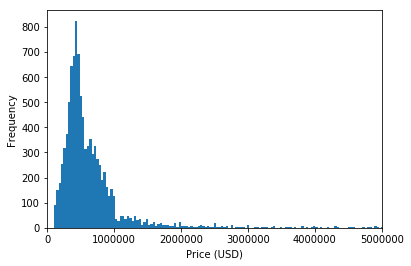

In [4]:
%%time
%matplotlib inline
plt.xlim(0,.5e7)
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.hist(raw_df['price'].sample(10000),bins='auto')

In [5]:
#unique, counts = np.unique(x['borough'], return_counts=True)
#dict(zip(unique, counts))
baseline = np.zeros(raw_df['price'].shape) + np.median(raw_df['price'])
print("Baseline MAE: {}".format(mean_absolute_error(raw_df['price'],baseline)))
print("Baseline MSE: {}".format(mean_squared_error(raw_df['price'],baseline)))
print("Baseline median error: {}".format(median_absolute_error(raw_df['price'],baseline)))
print("Baseline mslog error: {}".format(mean_squared_log_error(raw_df['price'],baseline)))
print("Baseline variance score: {}".format(explained_variance_score(raw_df['price'],baseline)))
print("Baseline r^2 score: {}".format(r2_score(raw_df['price'],baseline)))

Baseline MAE: 801538.732415
Baseline MSE: 4.73061814968e+13
Baseline median error: 165000.0
Baseline mslog error: 0.590847155041
Baseline variance score: 0.0
Baseline r^2 score: -0.0094364505542


In [6]:
%%time
train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(X_reduced,df.values[:,32],test_size=.33)
forest = RandomForestRegressor(128)
forest.fit(train_x_PCA,train_y_PCA)
yhat = forest.predict(test_x_PCA)
print("MAE: {}".format(mean_absolute_error(test_y_PCA,yhat)))
print("MSE: {}".format(mean_squared_error(test_y_PCA,yhat)))
print("median error: {}".format(median_absolute_error(test_y_PCA,yhat)))
print("mslog error: {}".format(mean_squared_log_error(test_y_PCA,yhat)))
print("variance score: {}".format(explained_variance_score(test_y_PCA,yhat)))
print("r^2 score: {}".format(r2_score(test_y_PCA,yhat)))

MAE: 150006.694096
MSE: 4.06399655995e+12
median error: 16854.375
mslog error: 0.0424527638215
variance score: 0.940824011862
r^2 score: 0.940818497124
CPU times: user 8min 3s, sys: 3.03 s, total: 8min 6s
Wall time: 8min 25s


In [7]:
indices = np.array(np.argsort(abs(np.array(pca.components_[10]))))
for l,i in list(zip(np.array(labels)[indices],np.array(pca.components_[10])[indices]))[::-1]:
	print("{}: {}".format(l,i))

GROSS SQUARE FEET: 0.640664254056
LAND SQUARE FEET: -0.569736359711
poi type 5: -0.266783176349
poi type 12: 0.249752914261
poi type 10: 0.201222598219
poi type 4: -0.139391368752
# of bus_stop: 0.125349039019
poi type 2: -0.0999304893786
YEAR BUILT: 0.0926460840176
poi type 7: -0.0814568664299
poi type 8: 0.0746096139308
poi type 6: 0.0670596295698
# of subway_station: 0.0646194655613
poi type 9: 0.0594430148531
poi type 3: -0.0581930530786
total # of poi: -0.0560446871259
poi type 13: -0.0528945797027
poi type 11: -0.0446780201298
poi type 1: -0.0264921884647
# of MISDEMEANOR: 0.0180317032766
commercial: 0.0130846273457
mixed: -0.0130694348234
# of VIOLATION: -0.00749211327401
residencial: -0.00444977244461
# of FELONY: 0.00422044400533
# of roads: -0.00237615619717


In [8]:
# Get numerical feature importances
importances = list(forest.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(train_x_PCA.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda train_x_PCA: train_x_PCA[1], reverse = True)
# Print out the feature and importances
#print(feature_importances)
["{}: {}".format(*pair) for pair in feature_importances]

['10: 0.43',
 '15: 0.16',
 '1: 0.09',
 '17: 0.06',
 '0: 0.05',
 '4: 0.04',
 '3: 0.02',
 '8: 0.02',
 '9: 0.02',
 '11: 0.02',
 '2: 0.01',
 '5: 0.01',
 '6: 0.01',
 '7: 0.01',
 '12: 0.01',
 '13: 0.01',
 '14: 0.01',
 '16: 0.01',
 '18: 0.01']

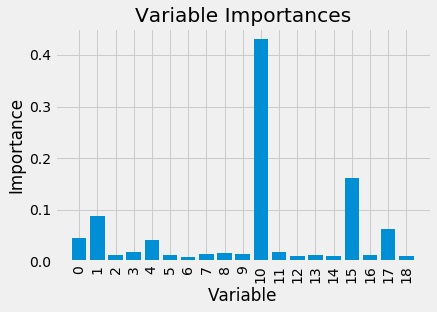

In [9]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, list(train_x_PCA.columns), rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [10]:
%%time
## Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
#tree = forest.estimators_[5]
# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = list(train_x.columns), rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file //DO NOT DO THIS HOLY CRAP
#graph.write_png('tree.png')
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_x, train_y)
# Extract the small tree
tree_small = rf_small.estimators_[5]

CPU times: user 2.03 s, sys: 109 ms, total: 2.14 s
Wall time: 2.38 s


In [11]:
%%time
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(train_x.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

CPU times: user 594 ms, sys: 344 ms, total: 938 ms
Wall time: 2.87 s
